In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [7]:
from src.transformers.sklearn_model import SklearnModel
import gensim
from src.load_data import LoadData
from src.config import Config
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
import numpy as np
from scipy.stats import spearmanr
import dill
from src.plotting import Plotting
from src.load_data import LoadData
from src.molecule_pairs_opt import MoleculePairsOpt
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver
from src.molecular_pairs_set import MolecularPairsSet
from scipy.stats import spearmanr
from src.transformers.embedder import Embedder
from src.transformers.encoder import Encoder
import matplotlib.pyplot as plt
from src.transformers.CustomDatasetEncoder import CustomDatasetEncoder
from src.transformers.load_data_encoder import LoadDataEncoder
from torch.utils.data import DataLoader
from src.analog_discovery.cosine_similarity import CosineSimilarity
from rdkit import Chem

## params

In [8]:
data_folder= '/Users/sebas/projects/data/'
janssen_path = data_folder + 'drug_plus.mgf'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
dataset_path= data_folder +'merged_gnps_nist_20240311_unique_smiles_1_million.pkl'
model_path = data_folder + 'best_model_20240319_v2_512u_5_layers.ckpt'

In [9]:
config=Config()

In [10]:
config.D_MODEL=512
config.N_LAYERS=5

## open janssen data

In [11]:
loader_saver = LoaderSaver(
        block_size=100,
        pickle_nist_path='',
        pickle_gnps_path='',
        pickle_janssen_path=output_janssen_file,
    )

In [12]:
all_spectrums_janssen = loader_saver.get_all_spectrums(
            janssen_path,
            100000000,
            use_tqdm=True,
            use_nist=False,
            config=config,
            use_janssen=True,
        )

  0%|                                                                                                                                                                 | 2033/100000000 [00:01<18:40:24, 1487.53it/s]


We reached the end of the array at index 2033


## open ref data

In [13]:
with open(dataset_path, 'rb') as file:
            dataset = dill.load(file)

In [14]:
all_spectrums_reference= dataset['molecule_pairs_train'].spectrums_original +\
                    dataset['molecule_pairs_val'].spectrums_original + \
                        dataset['molecule_pairs_test'].spectrums_original


In [15]:
all_spectrums_reference[0].params

{'pepmass': (545.0, None),
 'charge': [0],
 'mslevel': '2',
 'source_instrument': 'LC-ESI-Ion Trap',
 'filename': '20111105_Jenia_Ger_Scytonemin_MH_545_qb.1.1..mgf',
 'seq': '*..*',
 'ionmode': 'Positive',
 'organism': 'GNPS-LIBRARY',
 'name': 'Scytonemin M+H',
 'pi': 'Gerwick',
 'datacollector': 'Amanda',
 'smiles': 'OC1=CC=C(\\C=C2\\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\\C(=C/C4=CC=C(O)C=C4)C3=O)=C3C4=C(C=CC=C4)N=C23)C=C1',
 'inchi': 'InChI=1S/C36H20N2O4/c39-21-13-9-19(10-14-21)17-25-33-29(23-5-1-3-7-27(23)37-33)31(35(25)41)32-30-24-6-2-4-8-28(24)38-34(30)26(36(32)42)18-20-11-15-22(40)16-12-20/h1-18,39-40H/b25-17+,26-18+',
 'inchiaux': 'CGZKSPLDUIRCIO-RPCRKUJJSA-N',
 'pubmed': 'N/A',
 'submituser': 'mwang87',
 'libraryquality': '1',
 'spectrumid': 'CCMSLIB00000001550',
 'scans': '1'}

In [16]:
all_spectrums_gnps = [s for s in all_spectrums_reference if s.params['spectrumid'].startswith('CCMS')]

In [17]:
all_spectrums_nist=[s for s in all_spectrums_reference if not(s.params['spectrumid'].startswith('CCMS'))]

## Find those instances that are not in reference

In [18]:
canon_smiles_reference = [Chem.CanonSmiles(s.smiles) for s in all_spectrums_reference]
canon_smiles_janssen =   [Chem.CanonSmiles(s.smiles) for s in all_spectrums_janssen]
janssen_indexes_in_ref= [i for i,s in enumerate(canon_smiles_janssen) if s in canon_smiles_reference]
janssen_indexes_not_in_ref = [i for i,s in enumerate(canon_smiles_janssen) if s not in canon_smiles_reference]

In [19]:
len(janssen_indexes_in_ref),len(janssen_indexes_not_in_ref)

(1622, 411)

In [20]:
all_spectrums_janssen = [all_spectrums_janssen[index] for index in janssen_indexes_not_in_ref]

## load encoder

In [21]:
encoder= Encoder(model_path, D_MODEL=int(config.D_MODEL),N_LAYERS=int(config.N_LAYERS))

Using cosine library from Pytorch?: True


## data loader

In [22]:
dataset_janssen= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_janssen)
dataloader_janssen= DataLoader(dataset_janssen, batch_size=config.BATCH_SIZE,  num_workers=0)


Preprocessing all the data ...


411it [00:01, 367.97it/s]

Finished preprocessing 
loading data
Normalizing intensities


In [23]:
dataset_reference= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_reference)
dataloader_reference= DataLoader(dataset_reference, batch_size=config.BATCH_SIZE,  num_workers=0)

Preprocessing all the data ...


326386it [00:04, 76896.60it/s]


Finished preprocessing 
loading data
Normalizing intensities


In [24]:
dataset_nist= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_nist)
dataloader_nist= DataLoader(dataset_nist, batch_size=config.BATCH_SIZE,  num_workers=0)

Preprocessing all the data ...


263745it [00:02, 88520.98it/s]


Finished preprocessing 
loading data
Normalizing intensities


In [25]:
dataset_gnps= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_gnps)
dataloader_gnps= DataLoader(dataset_gnps, batch_size=config.BATCH_SIZE,  num_workers=0)

Preprocessing all the data ...


62641it [00:01, 49574.43it/s]


Finished preprocessing 
loading data
Normalizing intensities


## forward

In [26]:
embeddings_janssen= encoder.get_embeddings(dataloader_janssen)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)


In [27]:
embeddings_reference = encoder.get_embeddings(dataloader_reference)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

In [28]:
#embeddings_nist = encoder.get_embeddings(dataloader_nist)

In [29]:
#embeddings_gnps = encoder.get_embeddings(dataloader_gnps)

## compute similarities

In [93]:
similarities= CosineSimilarity.batch_cosine_similarity_combinations(embeddings_janssen, embeddings_reference)

In [94]:
similarities.shape

(411, 326386)

## heat map

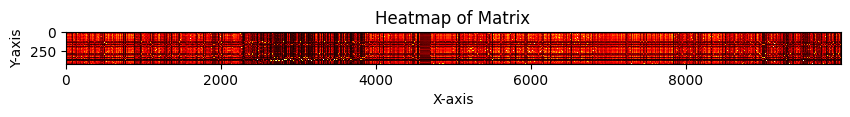

In [95]:
plt.figure(figsize=(10,100))
plt.imshow(similarities[:, 0:10000], cmap='hot', interpolation='nearest')
#plt.colorbar()  # Add colorbar to show scale
plt.title('Heatmap of Matrix')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

## Show PCA

In [96]:
from src.analog_discovery.pca_embeddings import PCAEmbeddings

In [97]:
pca = PCAEmbeddings()

In [98]:
pca.fit(embeddings_reference)

In [99]:
pca_ref= pca.transform(embeddings_reference)

In [100]:
pca_janssen= pca.transform(embeddings_janssen)

In [101]:
#pca_nist= pca.transform(embeddings_nist)

In [102]:
#pca_gnps= pca.transform(embeddings_gnps)

In [103]:
from src.plotting import Plotting

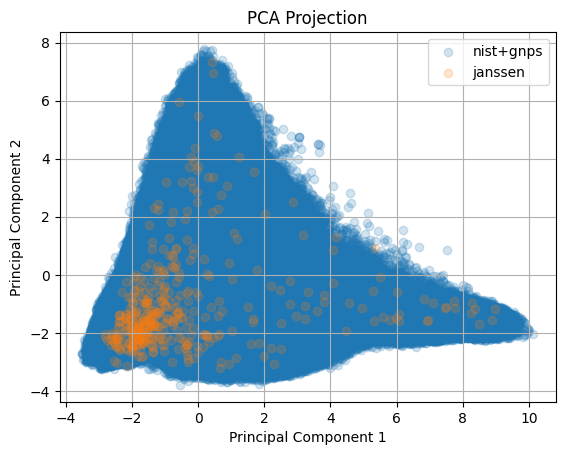

In [104]:
Plotting.plot_n_pca([pca_ref, pca_janssen,], ['nist+gnps','janssen', ], alpha=0.2)

## Use a mask for defining valid mass differences

In [105]:
similarities.shape

(411, 326386)

In [106]:
mass_reference = np.array([s.precursor_mz for s in all_spectrums_reference])
mass_janssen = np.array([s.precursor_mz for s in all_spectrums_janssen])

In [107]:
# Reshape A and B to make broadcasting work
mass_reference_reshaped = mass_reference.reshape(1, -1)
mass_janssen_reshaped = mass_janssen.reshape(-1, 1)

# Calculate differences
mass_diffs = np.abs(mass_reference_reshaped - mass_janssen_reshaped)

In [108]:
mass_diffs

array([[157.8726, 279.9876, 301.8726, ..., 259.0592, 259.0592, 259.0592],
       [177.9044, 300.0194, 321.9044, ..., 239.0274, 239.0274, 239.0274],
       [241.7821, 363.8971, 385.7821, ..., 175.1497, 175.1497, 175.1497],
       ...,
       [276.8668, 398.9818, 420.8668, ..., 140.065 , 140.065 , 140.065 ],
       [121.1082,   1.0068,  22.8918, ..., 538.04  , 538.04  , 538.04  ],
       [207.9443, 330.0593, 351.9443, ..., 208.9875, 208.9875, 208.9875]])

In [109]:
mass_diffs.shape

(411, 326386)

In [110]:
mass_diffs[mass_diffs <= config.MAX_MASS_DIFF]=1
mass_diffs[mass_diffs > config.MAX_MASS_DIFF]=0

In [111]:
mass_diffs.shape[0]*mass_diffs.shape[1]

134144646

In [112]:
similarities = mass_diffs*similarities

## Based on the similarities compute the similarity score of the match spectrum

In [113]:
arg_max_sim= np.argmax(similarities, axis=1)

In [114]:
max_sim = np.max(similarities, axis=1)

In [115]:
spectrums_retrieved = [all_spectrums_reference[ind] for ind in arg_max_sim]

In [116]:
smiles_retrieved = [s.smiles for s in spectrums_retrieved]

In [117]:
smiles_janssen = [s.smiles for s in all_spectrums_janssen]

In [118]:
from src.tanimoto import Tanimoto

In [119]:
tanimoto_retrieved = [Tanimoto.compute_tanimoto_from_smiles(s0,s1) for s0, s1 in zip(smiles_janssen, smiles_retrieved)]

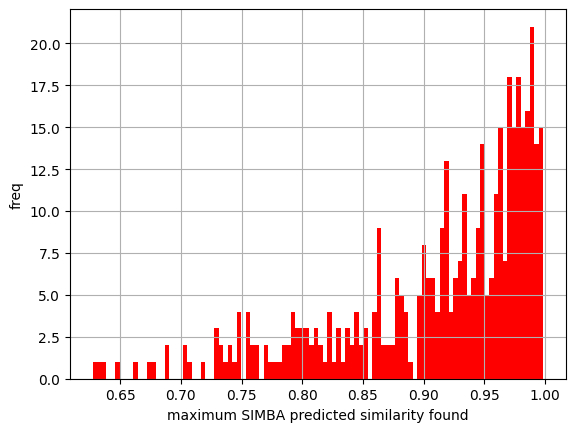

In [212]:
_=plt.hist(max_sim, color='r', bins=100)
plt.xlabel('maximum SIMBA predicted similarity found')
plt.ylabel('freq')
plt.grid()

Text(0, 0.5, 'frequency')

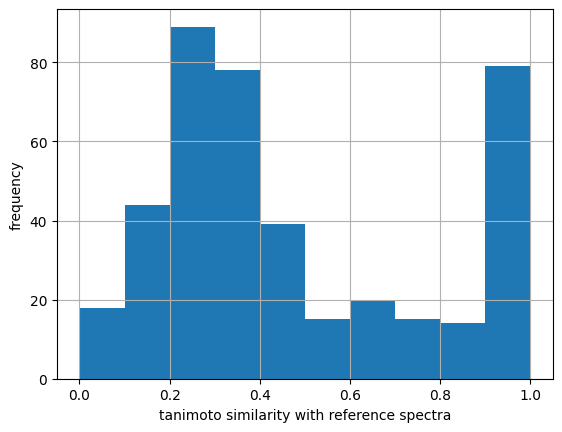

In [121]:
plt.hist(tanimoto_retrieved)
plt.grid()
plt.xlabel('tanimoto similarity with reference spectra')
plt.ylabel('frequency')

In [122]:
tanimoto_retrieved= np.array(tanimoto_retrieved)

In [123]:
tanimoto_retrieved[tanimoto_retrieved==1].shape[0]/tanimoto_retrieved.shape[0]

0.15085158150851583

In [124]:
tanimoto_retrieved[tanimoto_retrieved>0.7].shape[0]/tanimoto_retrieved.shape[0]

0.26277372262773724

Text(0.5, 0, 'tanimoto')

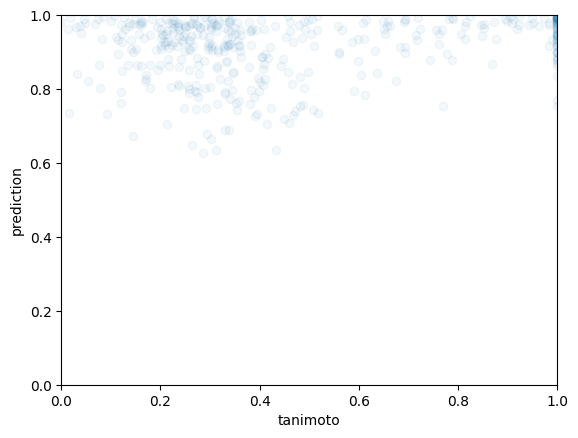

In [125]:
plt.scatter(tanimoto_retrieved, max_sim, alpha=0.05)
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('prediction')
plt.xlabel('tanimoto')

## Check which is the spectra that has wrong predictions

In [126]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
def calculate_mcs_similarity(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    
    # Perform MCS (Maximum Common Substructure) search
    mcs = rdFMCS.FindMCS([mol1, mol2])

    # Get SMARTS pattern from MCS result
    mcs_smarts = Chem.MolToSmarts(mcs.queryMol)
    
    # Calculate Tanimoto-like similarity
    mcs_mol = Chem.MolFromSmarts(mcs_smarts)
    #mcs_count = len(Chem.GetMolFrags(mcs_mol))
    mcs_count = mcs_mol.GetNumAtoms()
    similarity = mcs_count / (mol1.GetNumAtoms() + mol2.GetNumAtoms() - mcs_count)

    return similarity, mcs_mol

In [138]:
from rdkit.Chem import rdRascalMCES
def calculate_mces_sim(smiles1, smiles2, similarity_threshold=0.7):

    ad1 = Chem.MolFromSmiles(smiles1)
    ad2 = Chem.MolFromSmiles(smiles2)
    opts = rdRascalMCES.RascalOptions()
    opts.similarityThreshold = similarity_threshold
    opts.returnEmptyMCES = True
    results = rdRascalMCES.FindMCES(ad1, ad2, opts)
    if len(results) != 0:
        similarity_tier1= results[0].tier1Sim
        similarity_tier2= results[0].tier2Sim
    
        if similarity_tier2 != -1:
            return similarity_tier2 #if the lower threshold is not surpassed
        else:
            return similarity_tier1
    else:
        return None

In [139]:
len(all_spectrums_janssen)

411

In [140]:
len(spectrums_retrieved)

411

In [196]:
target_spectra=2

In [197]:
all_spectrums_janssen[target_spectra].params

{'pepmass': (303.2179, None),
 'rt': '4.62',
 'ionmode': 'Positive',
 'adduct': 'M+H',
 'charge': [1],
 'id': 'KBUZBQVCBVDWKX',
 'smiles': 'CCOCCn1c2ccccc2nc1N1CCCN(C)CC1',
 'formula': 'C17H26N4O',
 'filename': '2600129002_190419_MAS011_A2.mzXML',
 'drugbank.id': 'DB01084',
 'inchikey': 'KBUZBQVCBVDWKX-UHFFFAOYSA-N',
 'cpd': 'emedastine',
 'status': 'approved',
 'cas': 'N/A',
 'name': 'emedastine',
 'mslevel': '2',
 'tic': '745034110.742188',
 'pepmass_dev': '0.00140687837504099',
 'scan_number': '447',
 'param_submit_user': '',
 'param_sample_type': '',
 'param_comments': '',
 'param_algorithm': 'RMassBank',
 'param_creation_time': '2021-06-26 21:51:33',
 'scans': '7',
 'db': 'Inhouse',
 'class': 'Benzimidazoles',
 'num_peaks': '33',
 'param_consensus': 'consensus',
 'superclass': 'Organoheterocyclic compounds',
 'subclass': ''}

In [198]:
spectrums_retrieved[target_spectra].params

{'libraryquality': 1,
 'charge': [1],
 'pepmass': [278.0958],
 'ionmode': 'Positive',
 'name': ' 4,4,6-Trimethyl-1-(4-nitrophenyl)-3,4-dihydro-2(1H)-pyrimidinethione\n M+H',
 'inchi': 'N/A',
 'smiles': 'CC1=CC(N=C(N1C2=CC=C(C=C2)[N+](=O)[O-])S)(C)C',
 'organism': 'nist',
 'spectrumid': 'abcd'}

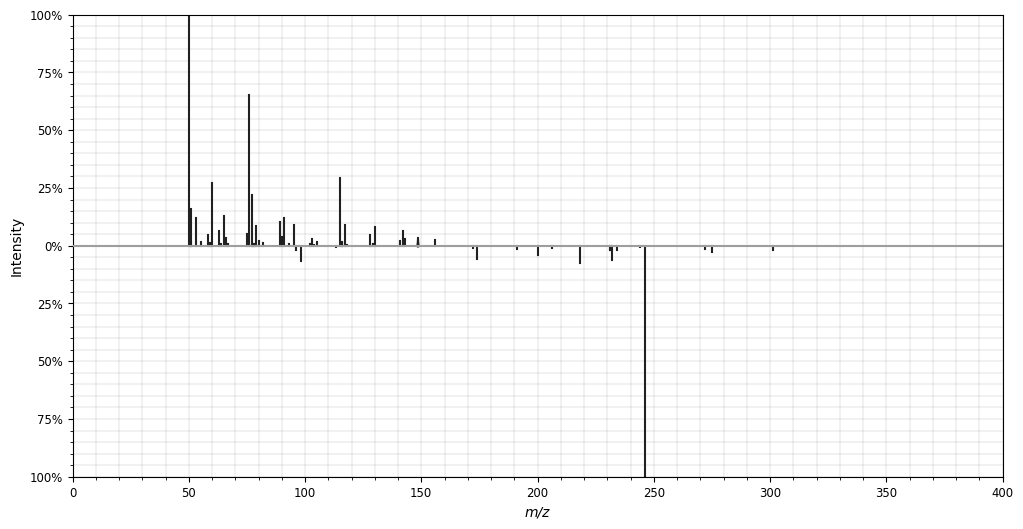

In [199]:
Plotting.plot_mirror_plot(spectrums_retrieved[target_spectra], all_spectrums_janssen[target_spectra])

In [200]:
len(max_sim)

411

In [201]:
max_sim[target_spectra]

0.928013265132904

In [202]:
tanimoto_retrieved[target_spectra]

0.22738589211618257

In [203]:
## mcs
sim_mcs, mol_mcs=calculate_mcs_similarity(smiles1=all_spectrums_janssen[target_spectra].params['smiles'], 
                         smiles2=spectrums_retrieved[target_spectra].params['smiles'])
sim_mcs

0.3225806451612903

In [204]:
sim_mces = calculate_mces_sim(smiles1=all_spectrums_janssen[target_spectra].params['smiles'], 
                         smiles2=spectrums_retrieved[target_spectra].params['smiles'])
sim_mces

0.6443701226309922

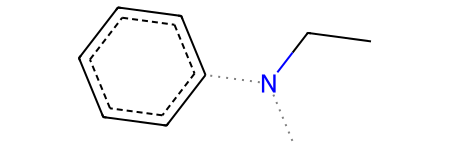

In [205]:
mol_mcs

In [206]:
## plot the molecules

In [207]:
Chem.CanonSmiles(all_spectrums_janssen[target_spectra].params['smiles'])

'CCOCCn1c(N2CCCN(C)CC2)nc2ccccc21'

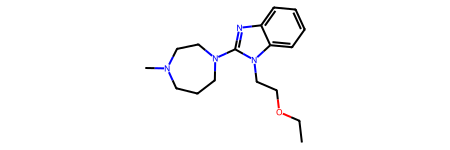

In [208]:
from rdkit import Chem
mol_janssen = Chem.MolFromSmiles(all_spectrums_janssen[target_spectra].params['smiles'])
mol_janssen

In [154]:
Chem.CanonSmiles(spectrums_retrieved[target_spectra].params['smiles'])

'CC(N)C1CCC(C(=O)Nc2ccncc2)CC1'

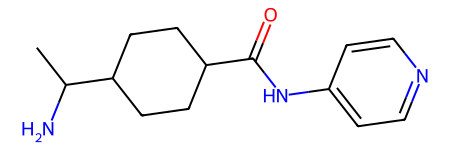

In [155]:
mol_ref = Chem.MolFromSmiles(spectrums_retrieved[target_spectra].params['smiles'])
mol_ref

## FIND SIMILARITY BASED ON MCS

In [156]:
len(smiles_retrieved)

411

In [157]:
len(smiles_janssen)

411

In [158]:
a=2

In [160]:
#mcs_similarity= []
#for s0,s1 in tqdm(zip(smiles_janssen, smiles_retrieved)):
#    similarity= calculate_mcs_similarity(s0, s1)
#    mcs_similarity.append(similarity)

In [161]:
mces_sims=[]
for s0,s1 in tqdm(zip(smiles_janssen, smiles_retrieved)):
    similarity= calculate_mces_sim(s0, s1)
    mces_sims.append(similarity)

57it [00:00, 156.07it/s]Too many matching bond pairs (1069) so can't continue.
Too many matching bond pairs (1211) so can't continue.
121it [00:00, 139.63it/s]Too many matching bond pairs (1095) so can't continue.
Too many matching bond pairs (1130) so can't continue.
Too many matching bond pairs (2060) so can't continue.
Too many matching bond pairs (1138) so can't continue.
Too many matching bond pairs (1264) so can't continue.
Too many matching bond pairs (1588) so can't continue.
Too many matching bond pairs (1552) so can't continue.
Too many matching bond pairs (1176) so can't continue.
Too many matching bond pairs (1069) so can't continue.
291it [00:00, 390.56it/s]Too many matching bond pairs (1313) so can't continue.
Too many matching bond pairs (1138) so can't continue.
Too many matching bond pairs (1859) so can't continue.
Too many matching bond pairs (1200) so can't continue.
411it [00:09, 42.66it/s] 


In [162]:
# Specify the bin width
bin_width = 0.1

# Calculate the number of bins based on the data range and bin width
bins = np.arange(0, 1 + bin_width, bin_width)

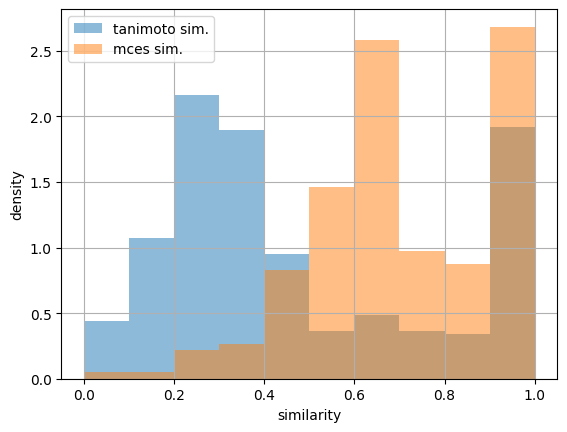

In [163]:
plt.hist(tanimoto_retrieved,alpha=0.5, label='tanimoto sim.', density=True, bins=bins)
plt.hist([m for m in mces_sims if m is not None],alpha=0.5, label='mces sim.', density=True, bins=bins)
plt.xlabel('similarity')
plt.ylabel('density')
plt.legend()
plt.grid()

In [164]:
mcs_similarity

[(1.0, <rdkit.Chem.rdchem.Mol at 0x34df14f20>),
 (0.4857142857142857, <rdkit.Chem.rdchem.Mol at 0x34df14f90>),
 (0.3225806451612903, <rdkit.Chem.rdchem.Mol at 0x34df15000>),
 (0.26666666666666666, <rdkit.Chem.rdchem.Mol at 0x34df14e40>),
 (0.3103448275862069, <rdkit.Chem.rdchem.Mol at 0x34df150e0>),
 (0.8095238095238095, <rdkit.Chem.rdchem.Mol at 0x34df15150>),
 (0.34210526315789475, <rdkit.Chem.rdchem.Mol at 0x34df151c0>),
 (0.2222222222222222, <rdkit.Chem.rdchem.Mol at 0x34df15230>),
 (0.20833333333333334, <rdkit.Chem.rdchem.Mol at 0x34df152a0>),
 (0.5, <rdkit.Chem.rdchem.Mol at 0x34df14eb0>),
 (0.25925925925925924, <rdkit.Chem.rdchem.Mol at 0x34df15380>),
 (0.7916666666666666, <rdkit.Chem.rdchem.Mol at 0x34df153f0>),
 (0.21568627450980393, <rdkit.Chem.rdchem.Mol at 0x34df15460>),
 (0.3877551020408163, <rdkit.Chem.rdchem.Mol at 0x34df154d0>),
 (0.7777777777777778, <rdkit.Chem.rdchem.Mol at 0x34df15540>),
 (0.2571428571428571, <rdkit.Chem.rdchem.Mol at 0x34df155b0>),
 (0.3255813953488

In [165]:
max_sim

array([0.87812096, 0.96354598, 0.92801327, 0.944287  , 0.76863569,
       0.89988029, 0.9811123 , 0.7972644 , 0.90086734, 0.98655397,
       0.79397583, 0.88095939, 0.85110909, 0.8952626 , 0.93550235,
       0.96228158, 0.96919423, 0.99026   , 0.94842935, 0.94792527,
       0.89500278, 0.81429821, 0.91987187, 0.98519093, 0.97172993,
       0.94533199, 0.91769367, 0.91259754, 0.952766  , 0.95628816,
       0.99770057, 0.94931591, 0.91397941, 0.85949564, 0.96958035,
       0.97042048, 0.92068607, 0.98389578, 0.98087281, 0.9715777 ,
       0.96036959, 0.84352028, 0.97496092, 0.97677702, 0.7433145 ,
       0.96702069, 0.98239797, 0.85115325, 0.98110551, 0.93558311,
       0.80631304, 0.87251592, 0.84323657, 0.99176627, 0.94295895,
       0.92688048, 0.80364251, 0.92342657, 0.9968406 , 0.93099934,
       0.96835232, 0.77405739, 0.96006978, 0.93270671, 0.90845454,
       0.97529399, 0.91490358, 0.83260661, 0.97840214, 0.98920298,
       0.98012817, 0.70444769, 0.93335319, 0.97205514, 0.73943

In [166]:
mcs_similarity=np.array(mcs_similarity)

In [167]:
true_positives= max_sim[0:200]

## saving of results

In [170]:
similarity_name= 'simba_2'

In [171]:
len(max_sim), len(tanimoto_retrieved), len(all_spectrums_janssen), len(smiles_retrieved), len(mces_sims), len(smiles_janssen), len(spectrums_retrieved)

(411, 411, 411, 411, 411, 411, 411)

In [172]:
results ={ 'preprocessed_all_spectrums_janssen':all_spectrums_janssen,
            'smiles_janssen':smiles_janssen,
          'smiles_retrieved':smiles_retrieved,
          'spectrums_retrieved':spectrums_retrieved,
            'tanimoto_retrieved':tanimoto_retrieved,
          'max_sim':max_sim,
          'mces_retrieved':mces_sims}

In [173]:
with open('./notebooks/discovery_search/results/'+similarity_name + '_results_analog_discovery_unknwon_compounds.pkl', 'wb') as f:
    dill.dump(results, f)